In [1]:
%load_ext autoreload
%autoreload 2

from wb_api_wrapper import *

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from IPython.display import display, HTML

import matplotlib.pyplot as plt 
%matplotlib inline


C:\Users\Admin\Anaconda3\lib\site-packages\pandas\io\wb.py:19: FutureWarning: 
The pandas.io.wb module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
#Pandas display options
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 200)

In [3]:
#Options for plots
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 12}

plt.rc('font', **font)
plt.rcParams["legend.fancybox"]=True
plt.rcParams["savefig.dpi"]=90

plot_options = dict(alpha=0.5)

def format_fig(ax):
    ax.set_xlim(0)
    ax.set_ylim(0)

In [4]:
#Searching the WB API database

search_wb("GDP").query("source=='World Development Indicators'");

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\io\wb.py:262: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  data = data.sort(columns='id')


# Data

### Pop and gdp

In [5]:
#gdp_pc_ppp  = get_wb("NY.GNP.PCAP.PP.CD") if gni else get_wb("NY.GDP.PCAP.PP.CD")#GDP per capita, PPP (constant 2011 international $)
gdp = get_wb("NY.GDP.MKTP.KD") #mkt but constant usd  #ional $)
pop = get_wb("SP.POP.TOTL") #populationb
gdp_ppp = get_wb("NY.GDP.MKTP.PP.KD")#GGDP, PPP (constant 2011 internat
gdp_pc=gdp/pop
gdp_pc_ppp = gdp_ppp/pop

### Emissions

In [6]:
emis_coo= get_wb("EN.ATM.CO2E.KT")*1000

emis_other= (get_wb("EN.ATM.GHGO.KT.CE")*1000).reindex(index=emis_coo.index,columns=emis_coo.columns)
emis_nox  = (get_wb("EN.ATM.NOXE.KT.CE")*1000).reindex(index=emis_coo.index,columns=emis_coo.columns)
emis_ch4  = (get_wb("EN.ATM.METH.KT.CE")*1000).reindex(index=emis_coo.index,columns=emis_coo.columns)


emis_coo_i   = emis_coo  .interpolate(axis=1)
emis_other_i = emis_other.interpolate(axis=1).fillna(0)
emis_nox_i   = emis_nox  .interpolate(axis=1).fillna(0)
emis_ch4_i   = emis_ch4  .interpolate(axis=1).fillna(0)


#emis_tot = emis_coo     +  emis_other + emis_nox   + emis_ch4 
emis_tot = emis_coo_i +  emis_other_i + emis_nox_i   + emis_ch4_i


emis_intens = emis_tot /gdp 
emis_pc     = emis_tot/pop

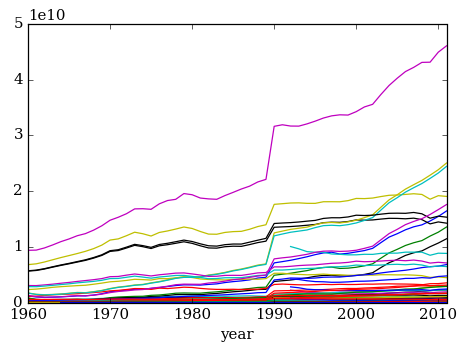

In [7]:
emis_tot.T.plot(legend=None)

### Dataframe

In [32]:
emis_coo["2011"].sort_values(ascending=False)

country
World                                             3.4649e+10
Low & middle income                               1.7475e+10
Middle income                                     1.7320e+10
High income                                       1.5234e+10
Upper middle income                               1.3166e+10
East Asia & Pacific (all income levels)           1.3003e+10
OECD members                                      1.2377e+10
High income: OECD                                 1.1589e+10
East Asia & Pacific (developing only)             1.0486e+10
China                                             9.0195e+09
Europe & Central Asia (all income levels)         6.7351e+09
North America                                     5.7914e+09
United States                                     5.3056e+09
Lower middle income                               4.1530e+09
High income: nonOECD                              3.7360e+09
European Union                                    3.5741e+09
Euro area       

In [8]:
df=pd.DataFrame()
df["emis_intens"]=emis_intens.stack()
df["gdp_pc"] = gdp_pc.stack()
df["gdp_pc_ppp"] = gdp_pc_ppp.stack()
df["pop"] = pop.stack()
df["emis_tot"] = emis_tot.stack()
df["emis_coo"] = emis_coo.stack()
df["emis_pc"]= emis_pc.stack()
df["emis_coo_pc"] = (emis_coo/pop).stack()


#Income gorups for countries and HIPC status
groups = pd.read_csv("counry_income_groups.csv",header =4,index_col=2).replace({"ROM":"ROU","ZAR":"COD"})  #they used old iso3 country for Zair (Congo) and Romania
groups.dropna(axis=0,how="all",inplace=True);

df= df.ix[groups.index] #keeps only actula countries (no macro regions or groups of countries)

data_all = df.reset_index()

#income bins
bins = [0]+ data_all.gdp_pc.quantile([.2,.4,.6,.8,1]).tolist()
bins = [0]+ data_all.gdp_pc.quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,1]).tolist()
bins[-1]=1e7 #"makes sure the last bins covers future incomes"
print("income bins", bins)


data_all["income_bins"] = pd.cut(data_all.gdp_pc,bins);



income bins [0, 351.41249544318487, 565.2893704840285, 871.83645191621508, 1519.7846528044547, 2451.3446550944204, 3809.3035029144053, 6531.0973006365311, 14671.133807044089, 26628.096507056798, 10000000.0]


In [9]:
#Current emissions
emis_ref = data_all.dropna().query("year=='2011'").emis_tot.sum()
print("Global GHG emissions in the sample: {emis:0.0f} GtCO2".format(emis=emis_ref*1e-9))

Global GHG emissions in the sample: 43 GtCO2


In [23]:
data_all.dropna().query("year=='2011'").sort_values(by="emis_tot",ascending=False)

,country,year,emis_intens,gdp_pc,gdp_pc_ppp,pop,emis_tot,emis_coo,emis_pc,emis_coo_pc,income_bins
1471,China,2011,2.7069e-03,3150.1660,10274.4944,1.3441e+09,1.1461e+10,9.0195e+09,8.5270,6.7103,"(2451.345, 3809.304]"
6930,United States,2011,4.6919e-04,44324.9445,49781.3575,3.1172e+08,6.4828e+09,5.3056e+09,20.7968,17.0202,"(26628.0965, 10000000]"
3117,India,2011,2.2250e-03,1063.1599,4685.8637,1.2474e+09,2.9509e+09,2.0743e+09,2.3656,1.6629,"(871.836, 1519.785]"
5446,Russian Federation,2011,2.5974e-03,6631.4642,22569.8143,1.4296e+08,2.4624e+09,1.8081e+09,17.2245,12.6473,"(6531.0973, 14671.134]"
3509,Japan,2011,2.8622e-04,36203.4339,34315.7984,1.2782e+08,1.3245e+09,1.1877e+09,10.3621,9.2918,"(26628.0965, 10000000]"
936,Brazil,2011,9.5575e-04,5744.4632,14830.8996,2.0052e+08,1.1009e+09,4.3941e+08,5.4903,2.1914,"(3809.304, 6531.0973]"
3169,Indonesia,2011,2.1820e-03,1638.8927,8870.2842,2.4481e+08,8.7547e+08,5.6398e+08,3.5761,2.3038,"(1519.785, 2451.345]"
2528,Germany,2011,2.7114e-04,38555.9660,42142.5489,8.1798e+07,8.5512e+08,7.2946e+08,10.4541,8.9178,"(26628.0965, 10000000]"
3221,"Iran, Islamic Rep.",2011,2.5178e-03,3850.8432,17949.2444,7.5184e+07,7.2896e+08,5.8660e+08,9.6956,7.8021,"(3809.304, 6531.0973]"
1263,Canada,2011,5.1131e-04,37176.1568,41567.4318,3.4343e+07,6.5281e+08,4.8546e+08,19.0086,14.1358,"(26628.0965, 10000000]"


## Lorenz curve

In [10]:
lending_group =pd.read_excel("CLASS.xls", skiprows=4, index_col="Economy", usecols=["Economy","Lending category"]).dropna(how="all").dropna(how="all",axis=1).squeeze()

In [11]:
#SPECILA TREATEMENT FOR INDIA
lending_group["India"]="Blend"

In [12]:
lending_group.unique()
colors = {
    'IDA':"#d7301f", 'IBRD':"#67a9cf", '..':"#999999", 'Blend':"#af8dc3"
}
edgecolors = {
    'IDA':"#ff0000", 'IBRD':"#053061", '..':"#4d4d4d", 'Blend':"#7b3294"
}


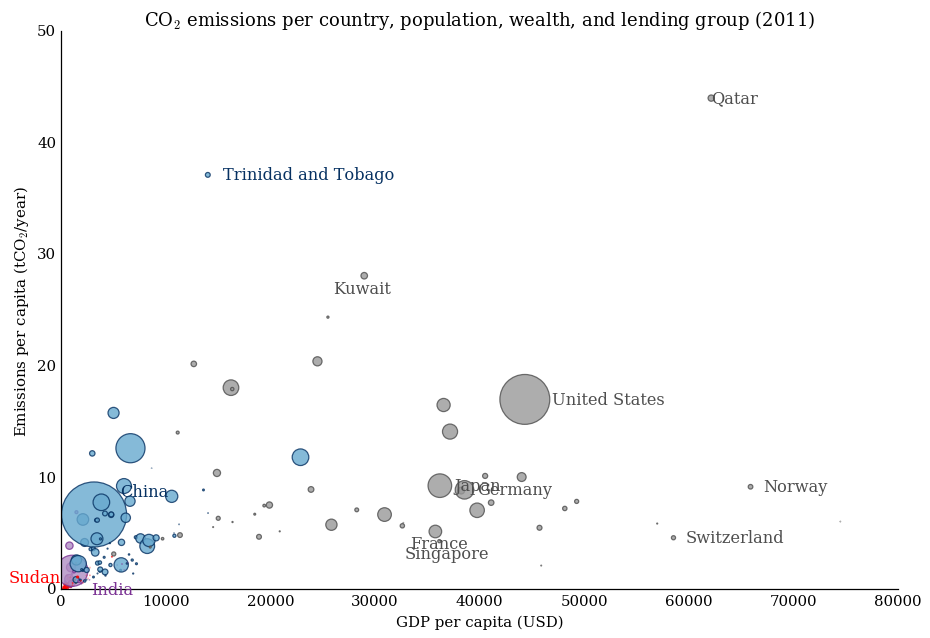

In [13]:
dsimple = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_coo","emis_coo_pc"]].sort_values(by="gdp_pc")

dsimple["country_color"] = dsimple.country.replace(lending_group.replace(colors))

names_=dsimple["country"]
logical=names_.isin(["United States","India","China","Qatar","Trinidad and Tobago", "Sudan",
                    "Japan","Germany","Switzerland" , "Norway", "Singapore", "France", "Kuwait"]) 
#+ names_.replace(lending_group).isin(["Blend"])

dsimple.to_excel("fig6.3_not_cumulative__.xlsx")

plt.figure(figsize=(12,8))
x=dsimple["gdp_pc"]
y=dsimple["emis_coo_pc"]
plt.scatter(x,y, s=1.5*dsimple["emis_coo"]/5e6, alpha=0.8, 
            c=dsimple.country.replace(lending_group.replace(colors)), 
            edgecolors=dsimple.country.replace(lending_group.replace(edgecolors)))
plt.xlim(0,80000)



offsets ={
    "United States":(22,0),"India":(15,-15),"China":(21,18),
    "Russian Federation":(14,1),"Sudan":(-50,5),
    "Japan":(12,0),"Germany":(10,0),"France":(-20, -10),
    "Switzerland":(10,0) ,"Kuwait":(-25,-10),"Qatar":(0,0),
    "Norway":(10,0), "Singapore":(-28,-10), "Trinidad and Tobago":(12,0)
}
ax=plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


plt.ylim(0,50)

#removes ticks 
for tic in ax.yaxis.get_major_ticks()+ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

if (logical is not None) :
    for label, x_, y_ in zip(names_[logical], x[logical], y[logical]):
        plt.annotate(
            label, 
            xy = (x_, y_), xytext = offsets[label],
            textcoords = 'offset points', ha = 'left', va = 'center',fontsize=13, color =edgecolors[lending_group[label]]
            #bbox = nonedict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            #arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
        )

         
#plt.scatter(x.iloc[0:40],y.iloc[0:40], s=dsimple["emis_tot"].iloc[0:40]/5e6, clip_on=False, color="red",alpha=1)
 
plt.title("CO$_2$ emissions per country, population, wealth, and lending group (2011)") 
        
plt.xlabel("GDP per capita (USD)")
plt.ylabel("Emissions per capita (tCO$_2$/year)")

plt.savefig("CO2 scatter.png")

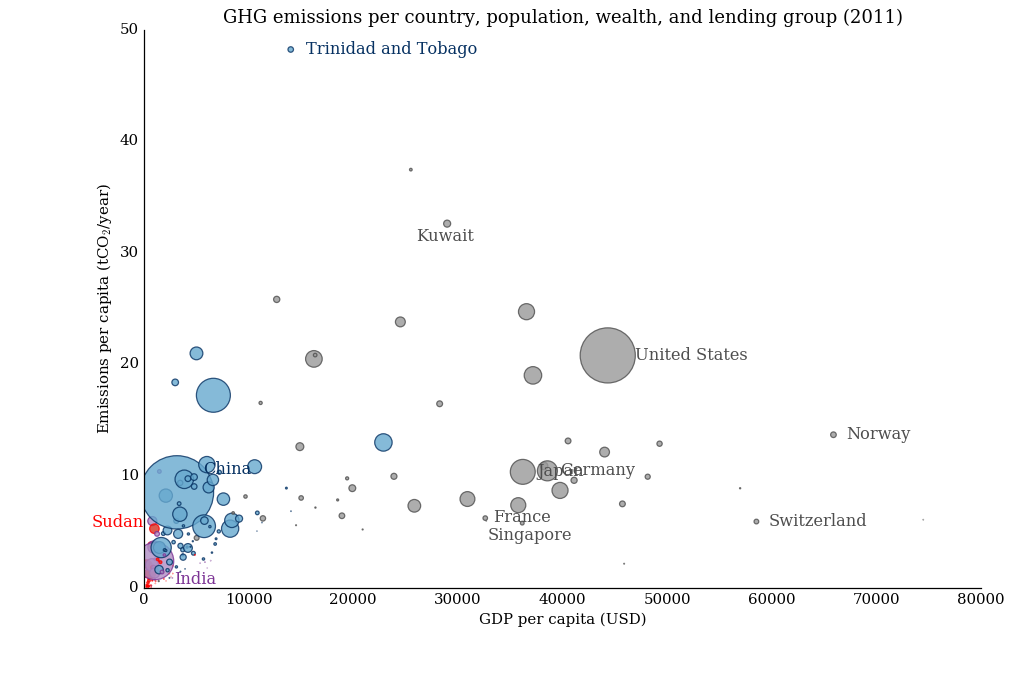

In [14]:
dsimple = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_tot","emis_pc"]].sort_values(by="gdp_pc")

dsimple["country_color"] = dsimple.country.replace(lending_group.replace(colors))

names_=dsimple["country"]
logical=names_.isin(["United States","India","China","Qatar","Trinidad and Tobago", "Sudan",
                    "Japan","Germany","Switzerland" , "Norway", "Singapore", "France", "Kuwait"]) 
#+ names_.replace(lending_group).isin(["Blend"])

dsimple.to_excel("fig6.3_not_cumulative__.xlsx")

plt.figure(figsize=(12,8))
x=dsimple["gdp_pc"]
y=dsimple["emis_pc"]
plt.scatter(x,y, s=1.5*dsimple["emis_tot"]/5e6, alpha=0.8, 
            c=dsimple.country.replace(lending_group.replace(colors)), 
            edgecolors=dsimple.country.replace(lending_group.replace(edgecolors)))
plt.xlim(0,80000)



offsets ={
    "United States":(22,0),"India":(15,-15),"China":(21,18),
    "Russian Federation":(14,1),"Sudan":(-50,5),
    "Japan":(12,0),"Germany":(10,0),"France":(-20, -10),
    "Switzerland":(10,0) ,"Kuwait":(-25,-10),"Qatar":(0,0),
    "Norway":(10,0), "Singapore":(-28,-10), "Trinidad and Tobago":(12,0)
}
ax=plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


plt.ylim(0,50)

#removes ticks 
for tic in ax.yaxis.get_major_ticks()+ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

if (logical is not None) :
    for label, x_, y_ in zip(names_[logical], x[logical], y[logical]):
        plt.annotate(
            label, 
            xy = (x_, y_), xytext = offsets[label],
            textcoords = 'offset points', ha = 'left', va = 'center',fontsize=13, color =edgecolors[lending_group[label]]
            #bbox = nonedict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            #arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
        )

         
#plt.scatter(x.iloc[0:40],y.iloc[0:40], s=dsimple["emis_tot"].iloc[0:40]/5e6, clip_on=False, color="red",alpha=1)
#plt.title("CO$_2$ emissions per country, population, wealth, and lending group")     
plt.title("GHG emissions per country, population, wealth, and lending group (2011)") 
        
plt.xlabel("GDP per capita (USD)")
plt.ylabel("Emissions per capita (tCO$_2$/year)")

plt.savefig("GHG scatter_natgeo.png")

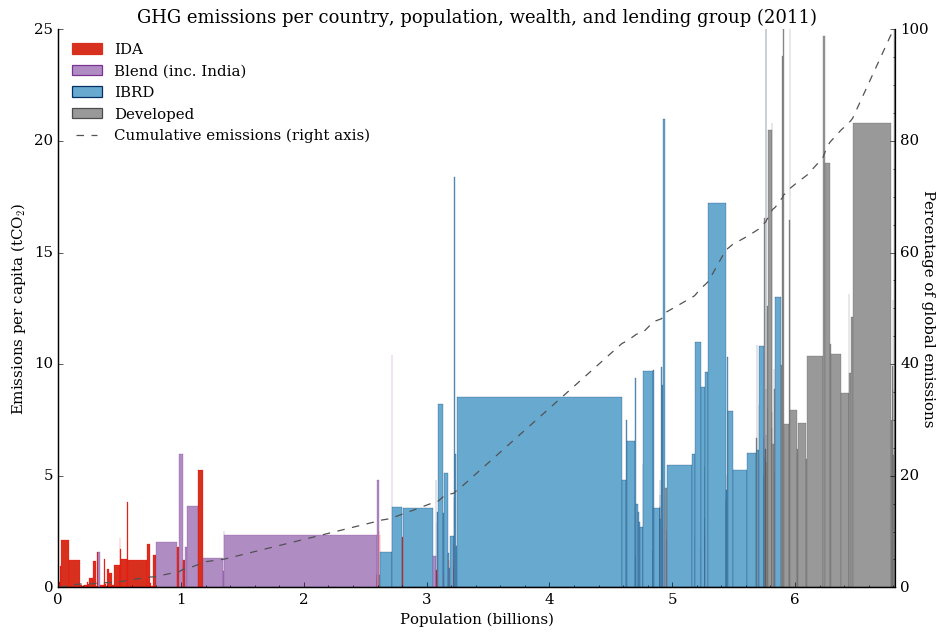

In [15]:
##all GHG only

dflor = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_tot","emis_pc"]].sort_values(by="gdp_pc")
dflor[["pop","emis_tot"]]=dflor[["pop","emis_tot"]]/1e9
dflor["cum_emis"]=100*dflor.emis_tot.cumsum()/dflor.emis_tot.cumsum().iloc[-1]
dflor["cum_pop"]=[0]+dflor["pop"][:-1].cumsum().tolist()

dflor["cum_pop2"]=dflor["pop"].cumsum()
#dflor["cum_pop"]-=dflor["cum_pop"].iloc[0] #offset x axis
#dflor.plot(x="cum_pop",y="cum_emis")
plt.figure(figsize=(12,8))

ax=plt.subplot(1,1,1)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ax.bar(dflor.cum_pop, dflor.emis_pc, width=dflor["pop"], linewidth=0.2, color=dsimple.country.replace(lending_group.replace(colors)), 
            edgecolor=dsimple.country.replace(lending_group.replace(edgecolors)))


ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel("Population (billions)")
plt.ylabel('Emissions per capita (tCO$_2$)')


ax2=ax.twinx()
ax2.plot(dflor.cum_pop2, dflor.cum_emis, "--", color="#525252")
ax2.set_ylabel("Percentage of global emissions", rotation=-90)
ax2.minorticks_on()

ax.spines['top'].set_color('none')
ax.set_ylim(ymax=25)
ax2.spines['top'].set_color('none')

title = "GHG emissions per country, population, wealth, and lending group (2011)"

#for tic in ax2.yaxis.get_major_ticks()+ax.yaxis.get_major_ticks()+ax.xaxis.get_major_ticks():
#    tic.tick1On = tic.tick2On = False

plt.title(title)

plt.xlim(xmax=dflor["pop"].sum())



if False:
    #Get artists and labels for legend and chose which ones to display
    handles, labels = ax.get_legend_handles_labels()
    display = (0,1,2)

    #Create custom artists
    simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
    anyArtist = plt.Line2D((0,1),(0,0), color='k')

    #Create legend from custom artist/label lists
    ax.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
              [label for i,label in enumerate(labels) if i in display]+['Simulation', 'Analytic'])


    cols = [colors['IDA'],colors['Blend'], colors['IBRD'], colors['..']]

    labels = ['IDA','Blend' , 'IBRD', 'Developped']
    dummies = [ax.plot([], [], ls='-', c=c)[0] for c in cols]        
    ax.legend(dummies, labels)


    
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

patchs=[
    mpatches.Patch(ec=colors['IDA'],  fc=colors['IDA'], label='IDA'),
    mpatches.Patch(ec=edgecolors['Blend'],fc=colors['Blend'], label='Blend (inc. India)'),
    mpatches.Patch(ec=edgecolors['IBRD'], fc=colors['IBRD'], label='IBRD'),
    mpatches.Patch(ec=edgecolors['..'],   fc=colors['..'], label='Developed'),
    mlines.Line2D([], [], ls="--", color='#525252', label='Cumulative emissions (right axis)')
         ]

ax.legend(handles=patchs, loc="upper left", prop=font,frameon=False)    


plt.savefig(title+".png")

plt.savefig(title+".eps")
dflor[["country","cum_pop","cum_emis"]].set_index("country").to_csv(title+".csv", index=True)




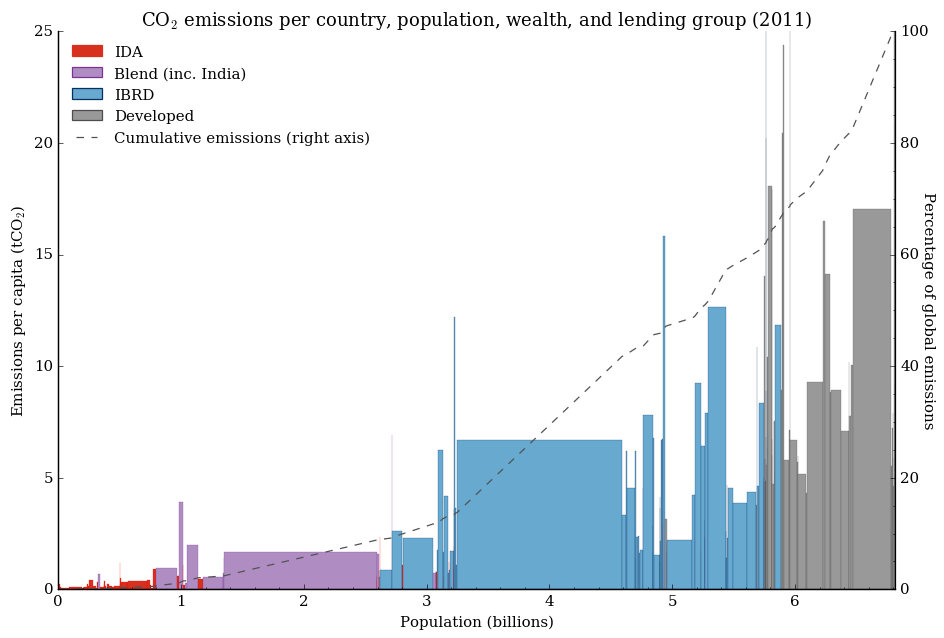

In [16]:
##CO2 only

dflor = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_coo","emis_coo_pc"]].sort_values(by="gdp_pc")
dflor[["pop","emis_coo"]]=dflor[["pop","emis_coo"]]/1e9
dflor["cum_emis"]=100*dflor.emis_coo.cumsum()/dflor.emis_coo.cumsum().iloc[-1]


dflor["cum_pop"]=[0]+dflor["pop"][:-1].cumsum().tolist()

dflor["cum_pop2"]=dflor["pop"].cumsum()
#dflor["cum_pop"]-=dflor["cum_pop"].iloc[0] #offset x axis
#dflor.plot(x="cum_pop",y="cum_emis")
plt.figure(figsize=(12,8))

ax=plt.subplot(1,1,1)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')



ax.bar(dflor.cum_pop, dflor.emis_coo_pc, width=dflor["pop"], linewidth=0.2, color=dsimple.country.replace(lending_group.replace(colors)), 
            edgecolor=dsimple.country.replace(lending_group.replace(edgecolors)))


ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel("Population (billions)")
plt.ylabel('Emissions per capita (tCO$_2$)')


ax2=ax.twinx()
ax2.plot(dflor.cum_pop2, dflor.cum_emis, "--", color="#525252")
ax2.set_ylabel("Percentage of global emissions", rotation=-90)
ax2.minorticks_on()

ax.spines['top'].set_color('none')
ax.set_ylim(ymax=25)
ax2.spines['top'].set_color('none')

title = "CO$_2$ emissions per country, population, wealth, and lending group (2011)"

#for tic in ax2.yaxis.get_major_ticks()+ax.yaxis.get_major_ticks()+ax.xaxis.get_major_ticks():
#    tic.tick1On = tic.tick2On = False

plt.title(title)

plt.xlim(xmax=dflor["pop"].sum())


    
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

patchs=[
    mpatches.Patch(ec=colors['IDA'],  fc=colors['IDA'], label='IDA'),
    mpatches.Patch(ec=edgecolors['Blend'],fc=colors['Blend'], label='Blend (inc. India)'),
    mpatches.Patch(ec=edgecolors['IBRD'], fc=colors['IBRD'], label='IBRD'),
    mpatches.Patch(ec=edgecolors['..'],   fc=colors['..'], label='Developed'),
    mlines.Line2D([], [], ls="--", color='#525252', label='Cumulative emissions (right axis)')
         ]

ax.legend(handles=patchs, loc="upper left", prop=font,frameon=False)    


plt.savefig(title+".png")

plt.savefig(title+".eps")
dflor[["country","cum_pop","cum_emis"]].set_index("country").to_csv(title+".csv", index=True)




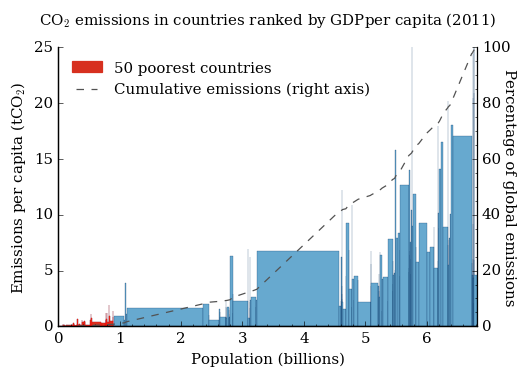

In [17]:
##CO2 50 poorest countries
dflor = data_all.query("year=='2011'")[["country","pop","gdp_pc_ppp","emis_coo","emis_coo_pc"]].sort_values(by="gdp_pc_ppp")
dflor[["pop","emis_coo"]]=dflor[["pop","emis_coo"]]/1e9
dflor["cum_emis"]=100*dflor.emis_coo.cumsum()/dflor.emis_coo.cumsum().iloc[-1]


dflor["cum_pop"]=[0]+dflor["pop"][:-1].cumsum().tolist()

dflor["cum_pop2"]=dflor["pop"].cumsum()
#dflor["cum_pop"]-=dflor["cum_pop"].iloc[0] #offset x axis
#dflor.plot(x="cum_pop",y="cum_emis")
plt.figure(figsize=(6,4))

ax=plt.subplot(1,1,1)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')



ax.bar(dflor.cum_pop, dflor.emis_coo_pc, width=dflor["pop"], linewidth=0.2, 
       color=colors["IBRD"], 
            edgecolor=edgecolors["IBRD"])

n=50
ax.bar(dflor.iloc[0:n].cum_pop, dflor.iloc[0:n].emis_coo_pc, width=dflor.iloc[0:n]["pop"], linewidth=0.2, 
       color=colors["IDA"], 
            edgecolor=edgecolors["IDA"])

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel("Population (billions)")
plt.ylabel('Emissions per capita (tCO$_2$)')


ax2=ax.twinx()
ax2.plot(dflor.cum_pop2, dflor.cum_emis, "--", color="#525252")
ax2.set_ylabel("Percentage of global emissions", rotation=-90)
ax2.minorticks_on()

ax.spines['top'].set_color('none')
ax.set_ylim(ymax=25)
ax2.spines['top'].set_color('none')

title = "CO$_2$ emissions in countries ranked by GDPper capita (2011)"

#for tic in ax2.yaxis.get_major_ticks()+ax.yaxis.get_major_ticks()+ax.xaxis.get_major_ticks():
#    tic.tick1On = tic.tick2On = False

plt.title(title+"\n", **font)

plt.xlim(xmax=dflor["pop"].sum())


    
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

patchs=[
    mpatches.Patch(ec=colors['IDA'],  fc=colors['IDA'], label='50 poorest countries'),
    mlines.Line2D([], [], ls="--", color='#525252', label='Cumulative emissions (right axis)')
         ]

ax.legend(handles=patchs, loc="upper left", prop=font,frameon=False)    


plt.savefig(title+".png")

plt.savefig(title+".eps")
dflor[["country","cum_pop","cum_emis"]].set_index("country").to_csv(title+".csv", index=True)




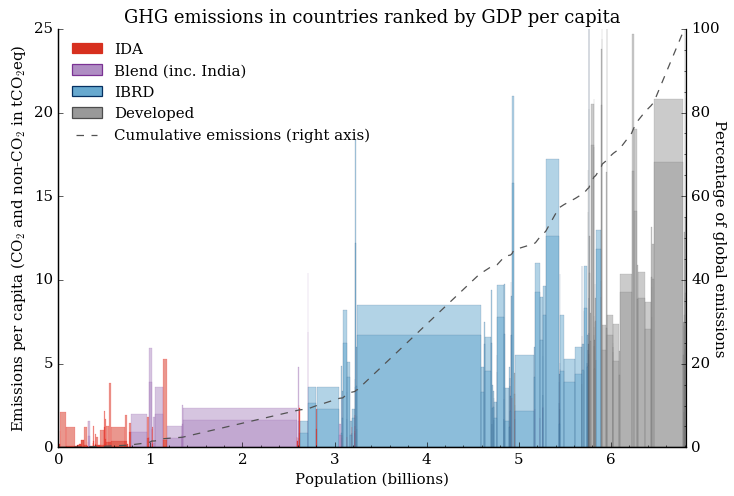

In [18]:
#CO2 and all GHG


dflor = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_pc","emis_tot","emis_coo","emis_intens","emis_coo_pc"]].sort_values(by="gdp_pc")
dflor[["pop","emis_coo"]]=dflor[["pop","emis_coo"]]/1e9
dflor["cum_emis"]=100*dflor.emis_coo.cumsum()/dflor.emis_coo.cumsum().iloc[-1]
dflor["cum_pop"]=[0]+dflor["pop"][:-1].cumsum().tolist()

dflor["cum_pop2"]=dflor["pop"].cumsum()
#dflor["cum_pop"]-=dflor["cum_pop"].iloc[0] #offset x axis
#dflor.plot(x="cum_pop",y="cum_emis")
plt.figure(figsize=(12*.75,8*.75))

ax=plt.subplot(1,1,1)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ax.bar(dflor.cum_pop, dflor.emis_pc, width=dflor["pop"], linewidth=0.2, 
       color=dsimple.country.replace(lending_group.replace(colors)), 
            edgecolor=dsimple.country.replace(lending_group.replace(edgecolors)), alpha=0.5)

ax.bar(dflor.cum_pop, dflor.emis_coo_pc, width=dflor["pop"], linewidth=0.2,
       color=dsimple.country.replace(lending_group.replace(colors)), 
            edgecolor=dsimple.country.replace(lending_group.replace(edgecolors)), alpha=0.5)


ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel("Population (billions)")
plt.ylabel('Emissions per capita (CO$_2$ and non-CO$_2$ in tCO$_2$eq)')


ax2=ax.twinx()
ax2.plot(dflor.cum_pop2, dflor.cum_emis, "--", color="#525252")
ax2.set_ylabel("Percentage of global emissions", rotation=-90)
ax2.minorticks_on()

ax.spines['top'].set_color('none')
ax.set_ylim(ymax=25)
ax2.spines['top'].set_color('none')

title = "GHG emissions in countries ranked by GDP per capita"

#for tic in ax2.yaxis.get_major_ticks()+ax.yaxis.get_major_ticks()+ax.xaxis.get_major_ticks():
#    tic.tick1On = tic.tick2On = False

plt.title(title)

plt.xlim(xmax=dflor["pop"].sum())



if False:
    #Get artists and labels for legend and chose which ones to display
    handles, labels = ax.get_legend_handles_labels()
    display = (0,1,2)

    #Create custom artists
    simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
    anyArtist = plt.Line2D((0,1),(0,0), color='k')

    #Create legend from custom artist/label lists
    ax.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
              [label for i,label in enumerate(labels) if i in display]+['Simulation', 'Analytic'])


    cols = [colors['IDA'],colors['Blend'], colors['IBRD'], colors['..']]

    labels = ['IDA','Blend' , 'IBRD', 'Developped']
    dummies = [ax.plot([], [], ls='-', c=c)[0] for c in cols]        
    ax.legend(dummies, labels)


    
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

patchs=[
    mpatches.Patch(ec=colors['IDA'],  fc=colors['IDA'], label='IDA'),
    mpatches.Patch(ec=edgecolors['Blend'],fc=colors['Blend'], label='Blend (inc. India)'),
    mpatches.Patch(ec=edgecolors['IBRD'], fc=colors['IBRD'], label='IBRD'),
    mpatches.Patch(ec=edgecolors['..'],   fc=colors['..'], label='Developed'),
    mlines.Line2D([], [], ls="--", color='#525252', label='Cumulative emissions (right axis)')
         ]

ax.legend(handles=patchs, loc="upper left", prop=font,frameon=False)    


plt.savefig(title+".png")

plt.savefig(title+".eps")
dflor[["country","cum_pop","cum_emis"]].set_index("country").to_csv(title+".csv", index=True)




In [19]:
plt.figure(figsize=(12,8))

for c in df_.index:
    x=gdp_pc_ppp.ix[c]
    y=(emis_coo_i).ix[c]
    plt.plot(pd.DataFrame([x,y],index=["x","y"]).T.x,pd.DataFrame([x,y],index=["x","y"]).T.y, color=edgecolors[lending_group[c]], alpha=.4)

NameError: name 'df_' is not defined

In [ ]:
plt.figure(figsize=(12,8))



for c in df_.index:
    x=data_all.query("country=='"+c+"'").set_index("year")["gdp_pc"]
    y=data_all.query("country=='"+c+"'").set_index("year")["emis_coo_pc"]
    plt.plot(x,y, color=edgecolors[lending_group[c]], alpha=.5)
    
plt.xlabel("GDP per capita (USD)")
plt.ylabel("Emissions per capita (tCO$_2$eq per year)")

plt.savefig("peaking_story.png")

In [ ]:
c

In [ ]:
df_

In [ ]:
dflor = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_tot"]].sort_values(by="gdp_pc")
dflor[["pop","emis_tot"]]=dflor[["pop","emis_tot"]]/1e9
dflor["cum_emis"]=dflor.emis_tot.cumsum()
dflor["cum_pop"]=[0]+dflor["pop"][:-1].cumsum().tolist()
#dflor["cum_pop"]-=dflor["cum_pop"].iloc[0] #offset x axis
#dflor.plot(x="cum_pop",y="cum_emis")


plt.figure(figsize=(12,8))
ax=plt.subplot(1,1,1)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ax.bar(dflor.cum_pop, dflor.cum_emis, width=dflor["pop"], linewidth=0.2, color=dsimple.country.replace(lending_group.replace(colors)), 
            edgecolor=dsimple.country.replace(lending_group.replace(edgecolors)))


ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel("Population (billions)")
plt.ylabel('Emissions (GtCO$_2$)')

title = "Countries ranked by GDP per capita"

plt.title(title)


plt.savefig("lorentz_2011_step.png")

plt.savefig("lorentz_2011_step.eps")
dflor[["country","cum_pop","cum_emis"]].set_index("country").to_csv("lorentz_2011_step.csv", index=True)



In [ ]:
plt.figure(figsize=(12,8))
#ax=plt.subplot(1,1,1)

for group in lending_group.unique():
    c = lending_group[lending_group.isin(["IDA"])].index
    x=emis_intens.ix[c].columns.astype(int).values
    y=emis_intens.ix[c].values
    #plt.plot(x,y, color = colors[group])

In [ ]:
emis_intens_perlndinggp = pd.concat([emis_intens,lending_group],axis=1).reset_index().dropna(subset=["Lending category"]).set_index(["Lending category","index"]).sort_index().dropna(how="all",axis=1).dropna(thresh =4)

In [ ]:
dflor = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_tot","emis_pc"]].sort("emis_pc")
dflor[["pop","emis_tot"]]=dflor[["pop","emis_tot"]]/1e9
dflor["cum_emis"]=dflor.emis_tot.cumsum()
dflor["cum_pop"]=[0]+dflor["pop"][:-1].cumsum().tolist()
#dflor["cum_pop"]-=dflor["cum_pop"].iloc[0] #offset x axis
#dflor.plot(x="cum_pop",y="cum_emis")


ax=plt.subplot(1,1,1)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ax.bar(dflor.cum_pop, dflor.emis_pc, width=dflor["pop"], linewidth=0.2, color = "#9ecae1", edgecolor="#3182bd")


ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel("Population (billions)")
plt.ylabel('Emissions per capita (tCO$_2$)')

title = "Countries ranked by emissions per capita"



plt.title(title)

plt.savefig(title+".png", dpi=600)

plt.savefig(title+".eps")
dflor[["country","cum_pop","cum_emis"]].set_index("country").to_csv(title+".csv", index=True)



In [ ]:
dflor = data_all.query("year=='2011'")[["country","pop","gdp_pc","emis_tot"]].sort("gdp_pc")
dflor["cum_emis"]=dflor.emis_tot.cumsum()
dflor["cum_pop"]=dflor["pop"].cumsum()
#dflor.plot(x="cum_pop",y="cum_emis")

plt.xlabel("Population (billions)")
plt.ylabel('Emissions (GtCO$_2$)')
plt.plot(dflor.cum_pop/1e9, dflor.cum_emis/1e9)
plt.savefig("lorentz_2011_lisse.png")

plt.savefig("lorentz_2011_lisse.eps")
dflor[["cum_pop","cum_emis"]].to_csv("lorentz_2011_lisse.csv", index=False)

In [ ]:
#What ending povety means
target_gdp_pc = 4230

#Emissions in LICs today
data2011= data_all.query("year=='2011'").copy()
LICs = data2011.ix[data2011.gdp_pc<target_gdp_pc].index
print("emissions in the LICs in 2011: {x:.2%}".format(x=data2011.ix[LICs].emis_tot.sum()/emis_ref))

print("population in the LICs in 2011: {x}".format(x=data2011.ix[LICs]["pop"].sum()))
print("population in the LICs in 2011: {x:.2%}".format(x=data2011.ix[LICs]["pop"].sum()/data2011["pop"].sum()))

#Countries with low income
country_lics = data2011.ix[LICs].country.tolist()
print(country_lics)
data2011.ix[LICs].country.to_csv( "countries_below_4000.txt", index=False, header="country")
len(LICs)


In [ ]:
data2011.query("gdp_pc<4000")["emis_tot"].sum()*1e-9

In [ ]:
data2011.query("gdp_pc<4000")["pop"].sum()*1e-9

In [ ]:
100* data2011.query("gdp_pc<4000")["emis_tot"].sum()/data2011["emis_tot"].sum()

In [ ]:
100* data2011.query("gdp_pc<4000")["pop"].sum()/data2011["pop"].sum()

In [ ]:
100* data2011.query("gdp_pc<4000")["emis_tot"].sum()/data2011["emis_tot"].sum()/( data2011.query("gdp_pc<4000")["pop"].sum()/data2011["pop"].sum())

In [ ]:
100* data2011.query("gdp_pc<2500")["emis_tot"].sum()/data2011["emis_tot"].sum()

In [ ]:
data2011.query("gdp_pc<2500")["pop"].sum()*1e-9

# Past relation between emissions and GDP

In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(data_all.gdp_pc,data_all.emis_pc,**plot_options)
ax.set_xlabel('GDP per capita')
ax.set_ylabel('tCO2 per capita')
format_fig(ax)
plt.savefig("emissions_vs_gdp.png")

In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(data_all.gdp_pc,data_all.emis_intens*1e6,**plot_options)
ax.set_xlabel('GDP per capita')
ax.set_ylabel('gCO2 per $')
format_fig(ax)
ax.set_ylim(ymax=2.2e3)
ax.set_xlim(xmax=25e3)

plt.plot([0,25e3],[400,400],color="red")

ax.scatter(data_all.query("country=='China'").gdp_pc,data_all.query("country=='China'").emis_intens*1e6,color="yellow")

plt.savefig("paf.png")

In [ ]:
data_all.query("emis_intens>800e-6");

### Population and GDP from SSP

In [ ]:
gdp_proj = pd.read_csv(
    "gdp_ssp.csv",index_col="country", dtype={"scenario":str}).query("scenario=='SSP5'").drop("scenario",axis=1).sort_index()

In [ ]:
pop_proj =1e6*pd.read_csv(
    "population_ssp.csv", index_col="country", dtype={"scenario":str}).query("scenario=='SSP5'").drop("scenario",axis=1).sort_index();


In [ ]:
gdp_pc_proj = 1e9*gdp_proj/pop_proj

In [ ]:
#Countries with low income
country_lics = data2011.ix[LICs].country.tolist()
print(country_lics)
data2011.ix[LICs].country.to_csv( "countries_below_4000.txt", index=False, header="country")

In [ ]:
data2011.ix[LICs,"gdp_pc"].plot(kind="kde")
gdp_pc_proj.ix[country_lics,"2030"].plot(kind="kde")
gdp_pc_proj.ix[country_lics,"2050"].plot(kind="kde")
plt.legend(["2011","2030","2050"])
plt.plot([4000, 4000],[0, 25*1e-5],color="black")
plt.plot([2500, 2500],[0, 25*1e-5],color="black")

plt.title("Projected GDP distribution among today LICS")

In [ ]:
data2011.query("10e3<gdp_pc<20e3").emis_tot.sum()/data2011.query("10e3<gdp_pc<20e3")["pop"].sum()

In [ ]:
hop=(1e6*data_all.query("gdp_pc<10e3")["emis_intens"])
hop.hist(cumulative='True',normed=True,bins=20)
plt.xlabel("")
plt.ylim(ymax=1)
plt.title("cumulative distribution of \nemission intensity countries below 10k" )
hop.quantile([0.80,0.85,0.90,0.91]),hop.mean()


In [ ]:
hop=(1e6*data_all.query("gdp_pc<40e3")["emis_intens"])
hop.hist(cumulative='True',normed=True,bins=20)
plt.title("cumulative distribution of \nemission intensity countries below 40k" )
hop.quantile([0.8,.81,.82,.83,0.85,0.9]), hop.mean()

# Simple projections

In [ ]:
!cat rcp26.csv  #Emissions RCP are in GtC

In [ ]:
emis_rcp=pd.read_csv("rcp26.csv",  dtype={'years': object}).set_index('years').squeeze()* 1e9*44/12  #converts to tCO2
mis_rcp*1e-9 #RCP in GtCO2

In [ ]:
data2011.emis_tot.sum()* 1e-9  #emissions in my data are in tCO2 as well
#http://www.epa.gov/climatechange/ghgemissions/global.html this page shows current emissions are about 30GtCO2

In [ ]:
inc_tresh_list = [1000, 2500, 4000, 4250, 4500, 4750, 5000, 6000]
inc_tresh_list = [ 4000]
for income_tresh in inc_tresh_list:
    countries = data2011.query("gdp_pc<"+str(income_tresh)).country
    em_intens = 800*1e-6

    emis_proj  = (gdp_proj.ix[countries]*em_intens*1e9).sum()
    years_proj = emis_proj.index.map(eval)

    years_to_plot = [2011]+years_proj.tolist()
    emis_proj_to_plot = [data2011.query("gdp_pc<"+str(income_tresh)).emis_tot.sum()]+emis_proj.tolist()
       

    rcp_to_plot = [data2011.emis_tot.sum()]+emis_rcp.tolist()

    plt.plot( years_to_plot,  100*np.array(emis_proj_to_plot)/np.array(rcp_to_plot) )
    
plt.ylabel("Share of CO$_2$ emissions \nconsistent with 2°C target (%)")
plt.legend(inc_tresh_list,loc="upper left")   
plt.ylim(ymax=100)


list(map(lambda x: x*1e-9,emis_proj_to_plot))

In [ ]:
data2011.query("gdp_pc<"+str(income_tresh)).emis_tot.sum()*1e-9

In [ ]:
inc_tresh_list = [1000, 2500, 4000,  5000]
#inc_tresh_list = [ 4000]
for income_tresh in inc_tresh_list:
    countries = data2011.query("gdp_pc<"+str(income_tresh)).country
    em_intens = 400*1e-6

    emis_proj  = (gdp_proj.ix[countries]*em_intens*1e9).sum()
    years_proj = emis_proj.index.map(eval)

    years_to_plot = [2011]+years_proj.tolist()
    emis_proj_to_plot = [data2011.query("gdp_pc<"+str(income_tresh)).emis_tot.sum()]+emis_proj.tolist()
    
    pop_proj_to_plot = [data2011.query("gdp_pc<"+str(income_tresh))["pop"].sum()]+pop_proj.ix[countries].sum().tolist()
    
    pop_tot_to_plot = [data2011["pop"].sum()]+pop_proj.sum().tolist()

    rcp_to_plot = [data2011.emis_tot.sum()]+emis_rcp.tolist()

    plt.plot( years_to_plot,  100*np.array(emis_proj_to_plot) * np.array(pop_tot_to_plot)/(np.array(pop_proj_to_plot)*np.array(rcp_to_plot) ))
    
plt.ylabel("Share of CO$_2$ emissions PER CAP \nconsistent with 2°C target (%)")
plt.legend(inc_tresh_list,loc="upper left")   
plt.ylim(ymax=100)

100*np.array(emis_proj_to_plot) * np.array(pop_tot_to_plot)/(np.array(pop_proj_to_plot)*np.array(rcp_to_plot) )

In [ ]:
inc_tresh_list = [1000, 2500, 4000, 4250, 4500, 4750, 5000, 6000]
inc_tresh_list = [ 4000]
for income_tresh in inc_tresh_list:
    countries = data2011.query("gdp_pc<"+str(income_tresh)).country
    em_intens = 800*1e-6

    emis_proj  = (gdp_proj.ix[countries]*em_intens*1e9).sum()
    years_proj = emis_proj.index.map(eval)

    years_to_plot = [2011]+years_proj.tolist()
    emis_proj_to_plot = [data2011.query("gdp_pc<"+str(income_tresh)).emis_tot.sum()]+emis_proj.tolist()
    
    

    rcp_to_plot = [data2011.emis_tot.sum()]+emis_rcp.tolist()

    plt.plot( years_to_plot,  1e-9*np.array(emis_proj_to_plot) )
    
plt.ylabel("CO$_2$ emissions (GtCO2)")
plt.legend(inc_tresh_list,loc="upper left")   


In [ ]:
inc_tresh_list = [1000, 2500, 4000,  5000]
#inc_tresh_list = [ 4000]
for income_tresh in inc_tresh_list:
    countries = data2011.query("gdp_pc<"+str(income_tresh)).country
    em_intens = 400*1e-6

    emis_proj  = (gdp_proj.ix[countries]*em_intens*1e9).sum()
    years_proj = emis_proj.index.map(eval)

    years_to_plot = [2011]+years_proj.tolist()
    emis_proj_to_plot = [data2011.query("gdp_pc<"+str(income_tresh)).emis_tot.sum()]+emis_proj.tolist()
    
    pop_proj_to_plot = [data2011.query("gdp_pc<"+str(income_tresh))["pop"].sum()]+pop_proj.ix[countries].sum().tolist()
    
    pop_tot_to_plot = [data2011["pop"].sum()]+pop_proj.sum().tolist()

    rcp_to_plot = [data2011.emis_tot.sum()]+emis_rcp.tolist()

    plt.plot( years_to_plot,  pop_proj_to_plot )
    
plt.ylabel("Population ")
plt.legend(inc_tresh_list,loc="upper left")   


### Fitting models

In [ ]:
def project_emissions(formula):
    print("\n"+formula)
    mod = smf.ols(formula, data2011).fit()
    mod.summary();

    simulation = data2011.set_index("country")
    for year in ["2030","2035","2040","2045","2050"]:
        simulation["gdp_pc"+year] =     gdp_pc_proj.ix[country_lics,year]
        simulation["pop"+year]=     pop_proj.ix[country_lics,year]
        simulation["income_bins"+year] = pd.cut(simulation["gdp_pc"+year],bins)

    simulation = simulation.dropna().reset_index()

    emis_proj=emis_pc_proj=pd.DataFrame(index=simulation.country)

    for year in ["2030","2035","2040","2045","2050"]:

        simulation["emis_pc_proj"+year] =(mod.predict(simulation.assign(income_bins=simulation["income_bins"+year])))
        simulation["emis_proj"+year]=simulation["emis_pc_proj"+year]*simulation["pop"+year]

        emis_pc_proj[year] = simulation[["country","emis_pc_proj"+year]].set_index("country")
        emis_proj[year] = simulation[["country","emis_proj"+year]].set_index("country")

    return emis_proj,mod

In [ ]:
formula="emis_pc ~ income_bins+ country - 1"
emis_proj, mod = project_emissions(formula)

100*emis_proj.sum()/emis_rcp



In [ ]:
formula="emis_pc ~ country - 1"
emis_proj, mod = project_emissions(formula)

100*emis_proj.sum()/emis_rcp

In [ ]:
formula="emis_pc ~ income_bins+country - 1"

print("\n"+formula)
mod = smf.ols(formula, data2011).fit()
mod.summary();

simulation = data2011.set_index("country")
for year in ["2030","2035","2040","2045","2050"]:
    simulation["gdp_pc"+year] =     gdp_pc_proj.ix[country_lics,year]
    simulation["pop"+year]=     pop_proj.ix[country_lics,year]
    simulation["income_bins"+year] = pd.cut(simulation["gdp_pc"+year],bins)

simulation = simulation.dropna().reset_index()

emis_proj=emis_pc_proj=pd.DataFrame(index=simulation.country)

for year in ["2030","2035","2040","2045","2050"]:

    simulation["emis_pc_proj"+year] =(mod.predict(simulation)) #simulation.assign(income_bins=simulation["income_bins"+year]
    simulation["emis_proj"+year]=simulation["emis_pc_proj"+year]*simulation["pop"+year]

    emis_pc_proj[year] = simulation[["country","emis_pc_proj"+year]].set_index("country")
    emis_proj[year] = simulation[["country","emis_proj"+year]].set_index("country")



In [ ]:
simulation.columns

In [ ]:
simulation[["income_bins","income_bins2050"]]

In [ ]:
mod.summary()

In [ ]:
#Version with corrected error on intensity

mod = smf.ols(formula, data2011).fit()
#mod_weighted = smf.wls(formula, data2011, weights = data2011["pop"]).fit()

##"Predicted 2011")
data2011["intens_pred"] = mod.predict(data2011)
data2011["emis_2011_pred"] =data2011["intens_pred"]*data2011["gdp_pc"]*data2011["pop"]
#e_w_2011 =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]

data2011["intens_error"] = data2011["intens_pred"] -data2011["emis_intens"]


print("error in 2011 ",data2011["emis_2011_pred"].sum() / emis_ref-1)

#projection parameters
LICs = data2011.ix[data2011.gdp_pc<4000].country
print("number of LIC countries ", len(LICs))

simulation = data2011.set_index("country")
for year in ["2030","2035","2040","2045","2050"]:

    simulation["gdp_pc_"+year] = gdp_proj.ix[LICs,year]
    simulation["pop_"+year]= pop_proj.ix[LICs,year]

simulation = simulation.dropna().reset_index()

emis_proj = pd.DataFrame(index = gdp_proj.index)

for year in ["2030","2035","2040","2045","2050"]:
    simulation.inc_bins = pd.cut(simulation["gdp_pc_"+year],bins)

    

    #predicted with siuml
    simulation["gdp_"+year]=simulation["gdp_pc_"+year]*simulation["pop_"+year] 
    simulation["emis_proj_"+year] =(mod.predict(simulation)-simulation["intens_error"])*simulation["gdp_"+year]# - e_2011[LICs.index].values
    #simulation["emis_proj_weighted_"+year] =mod_weighted.predict(simulation)*simulation["gdp_"+year] #- e_w_2011[LICs.index]
    emis_proj[year] = simulation[["country","emis_proj_"+year]].set_index("country")


#Simulations

#Fitting different models

In [ ]:
def project_emissions(formula, data):
    print("\n"+formula)
    
    mod = smf.ols(formula, data).fit()
    mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

    
    print("\n========= Predicted 2011")
    simulation = data2011
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=emis_tot.sum()/emis_ref-1,
            y=emis_tot_weighted.sum()/emis_ref-1)
         )
    
    e_ref = emis_tot
    e_w_ref = emis_tot_weighted
    
    
    def report(emis_tot,emis_tot_weighted):
        print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=(emis_tot).sum()/emis_ref,
            y=(emis_tot_weighted).sum()/emis_ref)
         )
    
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print("\n========= Liting Income")
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc), inc_bins = pd.cut(data2011.gdp_pc,bins))
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print('\n==========Liting Income and population')
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc),inc_bins = pd.cut(data2011.gdp_pc,bins) )
    simulation.ix[LICs,"pop"] = pop_proj_2030.ix[data.ix[LICs].country].values
    
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print('\n==========new POPULATION, old income')
    simulation = data2011
    simulation.ix[LICs,"pop"] = pop_proj_2030.ix[data.ix[LICs].country].values
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]

    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    #simulation["emis_tot_weighted"] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    
    #simulation["emis_intens_pred"]
    #simulation["emis_pc"] = simulation["emis_intens_pred"]
    #simulation["emis_tot"] = simulation["emis_pc"]

    #print("\nEmissions increased by {x:0.1%}[{cil:0.1%}, {ciu:0.1%}]".format(
    #        x  =simulation.emis_tot.sum()/emis_ref-1,
    #        ciu=(simulation.emis_tot*iv_u/simulation["emis_intens_pred"]).sum()/emis_ref-1,
    #        cil=(simulation.emis_tot*iv_l/simulation["emis_intens_pred"]).sum()/emis_ref-1
    #     ))
    
    return mod,mod_weighted

### Constant emission intensity using 2011 data

In [ ]:
formula="emis_intens ~ country - 1"

In [ ]:
mod, mod_w= project_emissions(formula, data_all.query("year=='2011'").copy())
mod.summary();

In [ ]:
mod, mod_w= project_emissions(formula, data_all)

###Country fix effect and gdpglobal effect

everything signigicant

In [ ]:
formula="emis_intens ~ gdp_pc+country- 1 "

mod, mod_w  = project_emissions(formula, data_all)
#foo.summary()
mod.summary();

In [ ]:
formula="emis_intens ~ gdp_pc+country + emis_intens_last_year- 1"

mod, mod_w  = project_emissions(formula, data_all)
#foo.summary()
mod.summary();

###Square income

In [ ]:
formula="emis_intens ~ gdp_pc + I(gdp_pc**2)+ country  - 1"
mod, mod_w  = project_emissions(formula, data_all)
mod.summary();

###income bins

In [ ]:
formula="emis_pc ~ inc_bins- 1"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()

In [ ]:
formula="emis_pc ~ inc_bins+country - 1"
mod, mod_w  = project_emissions(formula, data_all)

#mod.summary(); #nothing significan

In [ ]:
formula="I(1e3*emis_intens) ~ inc_bins - 1"
mod, mod_w  = project_emissions(formula, data2011)

mod.summary()

In [ ]:
formula="I(1e3*emis_intens) ~ inc_bins+country - 1"
mod, mod_w  = project_emissions(formula, data2011)

mod.summary()

In [ ]:
formula="(emis_intens) ~ country +(gdp_pc):inc_bins + year+ inc_bins"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()

In [ ]:
formula="np.log(emis_intens) ~ country +np.log(gdp_pc):inc_bins + inc_bins"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()

In [ ]:
formula="np.log(emis_pc) ~ country-1 +np.log(gdp_pc):inc_bins +inc_bins"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()

In [ ]:
formula="emis_intens ~ inc_bins+country - 1"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary();

In [ ]:
formula="I(1e5*emis_intens) ~ inc_bins - 1"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()

###Country fix effect, year fix effect, and gdpglobal effect

year fixed effect non significant

In [ ]:
formula="emis_intens ~ gdp_pc+country+year- 1"
m,mw=project_emissions(formula, data_all)
m.summary();

#Projecting 

In [ ]:
def project_emissions_target(formula, data,target_gdp_pc):
    print("\n"+formula)
    
    data2011= data.query("year=='2011'").copy()
    LICs = data2011.ix[data2011.gdp_pc.clip(lower=target_gdp_pc)==target_gdp_pc].index
    
    mod = smf.ols(formula, data).fit()
    mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

    
    print("\n========= Predicted 2011")
    simulation = data2011
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=emis_tot.sum()/emis_ref-1,
            y=emis_tot_weighted.sum()/emis_ref-1)
         )
    
    e_ref = emis_tot
    e_w_ref = emis_tot_weighted
    
    
    def report(emis_tot,emis_tot_weighted):
        print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=(emis_tot).sum()/emis_ref,
            y=(emis_tot_weighted).sum()/emis_ref)
         )
    
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    
    print('\n==========Liting Income and population')
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc),inc_bins = pd.cut(data2011.gdp_pc,bins) )
    simulation.ix[LICs,"pop"] = pop_proj_2030.ix[data.ix[LICs].country].values
    
    simulation["emis_proj"] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    simulation["emis_proj_weighted"] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    return mod,mod_weighted

In [ ]:
def project_from_simul(formula, data, simulation):
    
    mod = smf.ols(formula, data).fit()
    mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

    data2011= data.query("year=='2011'").copy()
    
    ##print("\n========= Predicted 2011")
    e_2011 =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
    e_w_2011 =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
    """"print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=emis_tot.sum()/emis_ref-1,
            y=emis_tot_weighted.sum()/emis_ref-1)
         )"""
    
  
    #predicted with siuml
    simulation["emis_proj"] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"] - e_2011
    simulation["emis_proj_weighted"] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"] - e_w_2011
    
    #returns difference
    return simulation  #,emis_tot_weighted-e_w_ref)
    

In [ ]:
data2011= data_all.query("year=='2011'").copy()
simulation = data2011.set_index("country")
for year in ["2030","2035","2040","2045","2050"]:

    simulation["gdp_pc_"+year] = gdp_proj.ix[data2011.ix[LICs].country,year]
    simulation["pop_"+year]= pop_proj.ix[data2011.ix[LICs].country,year]


In [ ]:
formula="emis_intens ~ inc_bins- 1"

data2011= data_all.query("year=='2011'").copy().set_index("country")
data2011["emis_2011_actual"]=emis_tot["2011"]
data2011=data2011.reset_index();

In [ ]:

mod = smf.ols(formula, data2011).fit()
#mod_weighted = smf.wls(formula, data2011, weights = data2011["pop"]).fit()

##"Predicted 2011")
data2011["emis_2011_pred"] =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
#e_w_2011 =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
""""print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=emis_tot.sum()/emis_ref-1,
        y=emis_tot_weighted.sum()/emis_ref-1)
     )"""

print("error in 2011 ",data2011["emis_2011_pred"].sum() / emis_ref-1)

#projection parameters
LICs = data2011.ix[data2011.gdp_pc<4000].country
print("number of LIC countries ", len(LICs))

simulation = data2011.set_index("country")
for year in ["2030","2035","2040","2045","2050"]:

    simulation["gdp_pc_"+year] = gdp_proj.ix[LICs,year]
    simulation["pop_"+year]= pop_proj.ix[LICs,year]

simulation = simulation.dropna().reset_index()

emis_proj = pd.DataFrame(index = gdp_proj.index)

for year in ["2030","2035","2040","2045","2050"]:
    simulation.inc_bins = pd.cut(simulation["gdp_pc_"+year],bins)

    

    #predicted with siuml
    simulation["gdp_"+year]=simulation["gdp_pc_"+year]*simulation["pop_"+year] 
    simulation["emis_proj_"+year] =mod.predict(simulation)*simulation["gdp_"+year]# - e_2011[LICs.index].values
    #simulation["emis_proj_weighted_"+year] =mod_weighted.predict(simulation)*simulation["gdp_"+year] #- e_w_2011[LICs.index]
    emis_proj[year] = simulation[["country","emis_proj_"+year]].set_index("country")


In [ ]:
simulation.reindex_axis(sorted(simulation.columns), axis=1).to_csv("LICs_projeted.csv")

In [ ]:
simulation.head()

In [ ]:
emis_rcp26=pd.read_csv("rcp26.csv",  dtype={'years': object}).set_index('years').squeeze()* 1e9*44/12
emis_rcp26

In [ ]:
emis_proj["gdp_pc"]=gdp_pc_ppp["2011"]

In [ ]:
mydf = pd.DataFrame(emis_proj.query("gdp_pc<2500").sum(),columns=["emis 2500"])

In [ ]:
mydf["emis 4000"]=emis_proj.query("gdp_pc<4000").sum()
mydf["emis tot"]=emis_rcp26

In [ ]:
pop_proj["gdp_pc"]=gdp_pc_ppp["2011"]
mydf["pop 2500"]=pop_proj.query("gdp_pc<2500").sum()
mydf["pop 4000"]=pop_proj.query("gdp_pc<4000").sum()
mydf["pop tot"]=pop_proj.sum()

In [ ]:
mydf.to_excel("figure6.2.xlsx")

In [ ]:
#Version with corrected error on intensity

mod = smf.ols(formula, data2011).fit()
#mod_weighted = smf.wls(formula, data2011, weights = data2011["pop"]).fit()

##"Predicted 2011")
data2011["intens_pred"] = mod.predict(data2011)
data2011["emis_2011_pred"] =data2011["intens_pred"]*data2011["gdp_pc"]*data2011["pop"]
#e_w_2011 =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]

data2011["intens_error"] = data2011["intens_pred"] -data2011["emis_intens"]


print("error in 2011 ",data2011["emis_2011_pred"].sum() / emis_ref-1)

#projection parameters
LICs = data2011.ix[data2011.gdp_pc<4000].country
print("number of LIC countries ", len(LICs))

simulation = data2011.set_index("country")
for year in ["2030","2035","2040","2045","2050"]:

    simulation["gdp_pc_"+year] = gdp_proj.ix[LICs,year]
    simulation["pop_"+year]= pop_proj.ix[LICs,year]

simulation = simulation.dropna().reset_index()

emis_proj = pd.DataFrame(index = gdp_proj.index)

for year in ["2030","2035","2040","2045","2050"]:
    simulation.inc_bins = pd.cut(simulation["gdp_pc_"+year],bins)

    

    #predicted with siuml
    simulation["gdp_"+year]=simulation["gdp_pc_"+year]*simulation["pop_"+year] 
    simulation["emis_proj_"+year] =(mod.predict(simulation)-simulation["intens_error"])*simulation["gdp_"+year]# - e_2011[LICs.index].values
    #simulation["emis_proj_weighted_"+year] =mod_weighted.predict(simulation)*simulation["gdp_"+year] #- e_w_2011[LICs.index]
    emis_proj[year] = simulation[["country","emis_proj_"+year]].set_index("country")


In [ ]:
simulation.reindex_axis(sorted(simulation.columns), axis=1).to_csv("LICs_projeted_corerror.csv")

In [ ]:
simulation[["country","emis_proj_"+year]];

In [ ]:
emis_proj.dropna() 

In [ ]:
formula="emis_intens ~ inc_bins+country- 1"

data2011= data_all.query("year=='2011'").copy()

mod = smf.ols(formula, data2011).fit()
mod_weighted = smf.wls(formula, data2011, weights = data2011["pop"]).fit()

##print("\n========= Predicted 2011")
e_2011 =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
e_w_2011 =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
""""print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=emis_tot.sum()/emis_ref-1,
        y=emis_tot_weighted.sum()/emis_ref-1)
     )"""

print("error in 2011 ",e_2011.sum() / emis_ref-1)

#projection parameters
LICs = data2011.ix[data2011.gdp_pc<4000].country

print("number of LIC countries ", len(LICs))
simulation = data2011.set_index("country")
simulation.ix[LICs,"gdp_pc"] = gdp_pc_proj_2050.ix[LICs]
simulation.ix[LICs,"pop"]= pop_proj_2050.ix[LICs]


simulation.inc_bins = pd.cut(simulation.gdp_pc,bins)

simulation = simulation.dropna().reset_index()

#predicted with siuml
simulation["gdp"]=simulation["gdp_pc"]*simulation["pop"] 
#simulation["emis_proj"] =mod.predict(simulation)*simulation["gdp"] - e_2011
simulation["emis_proj"] =mod.predict(simulation)*simulation["gdp"] - e_2011
simulation["emis_proj_weighted"] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"] - e_w_2011

sim = simulation.set_index("country")
dat = data2011.set_index("country")

print("pop increased by", sim["pop"].sum()/ dat["pop"].sum() - 1)
print("gdp increased by", (sim["gdp_pc"]*sim["pop"]).sum()/ (dat["gdp_pc"]*dat["pop"]).sum() - 1)

print("emisisons increased by ", simulation.emis_proj.sum()/ emis_ref)
print("emisisons relative to 2050 by ", simulation.emis_proj.sum()/ emissions_RCP_2050)

print("(weighted) emisisons relative to 2050 by ", simulation.emis_proj_weighted.sum()/ emissions_RCP_2050)

###worst case intensitites

In [ ]:

simulation = data2011.set_index("country")

print("ratio emis today", ((simulation["gdp_pc"]*simulation["pop"]*simulation["emis_intens"]).ix[LICs].sum())/ emis_ref )
print("pop today",simulation.ix[LICs,"pop"].sum(), simulation.ix[LICs,"pop"].sum()/data2011["pop"].sum())


simulation.ix[LICs,"gdp_pc"] = gdp_pc_proj_2030.ix[LICs]

simulation.ix[LICs,"pop"]= pop_proj_2030.ix[LICs]
print("pop 2030", simulation.ix[LICs,"pop"].sum()/pop_proj_2030.sum())
simulation["emis_intens"]= mod.predict(simulation.reset_index())

((simulation["gdp_pc"]*simulation["pop"] *simulation["emis_intens"]).sum()- emis_ref)/ emissions_RCP_2030 

In [ ]:

simulation = data2011.set_index("country")
simulation.ix[LICs,"gdp_pc"] = gdp_pc_proj_2050.ix[LICs]
simulation.ix[LICs,"pop"]= pop_proj_2050.ix[LICs]
print(simulation.ix[LICs,"pop"].sum()/pop_proj_2050.sum())
simulation["emis_intens"]= mod.predict(simulation.reset_index())

((simulation["gdp_pc"]*simulation["pop"] *simulation["emis_intens"]).sum()- emis_ref)/ emissions_RCP_2050 

In [ ]:
###Projections of baseline emissions in 2050 for all countries


simulation_2050=pd.concat([pop_proj_2050,gdp_pc_proj_2050],axis=1).dropna()
simulation_2050=simulation_2050.ix[data_all.dropna().country.unique()].reset_index().rename(columns={"index":"country"}).dropna()
simulation_2050["inc_bins"]=pd.cut(simulation_2050.gdp_pc,bins)
simulation_2050.head(3)


formula = 'emis_intens ~ gdp_pc:inc_bins+country- 1 '
#formula = 'emis_intens ~ gdp_pc+I(gdp_pc**2)+country- 1 '
data=data_all
simulation=simulation_2050

data2011= data.query("year=='2011'").copy()


mod = smf.ols(formula, data).fit()
mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

emis_tot =mod.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
emis_tot_weighted =mod_weighted.predict(data2011)*data2011["gdp_pc"]*data2011["pop"]
print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=emis_tot.sum()/emis_ref-1,
        y=emis_tot_weighted.sum()/emis_ref-1)
     )
e_ref = emis_tot
e_w_ref = emis_tot_weighted

emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
def report(emis_tot,emis_tot_weighted):
    print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
        x=(emis_tot).sum()/emis_ref,
        y=(emis_tot_weighted).sum()/emis_ref)
     )

simulation_2050['emis_tot_proj'] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
simulation_2050['emis_tot_weighted'] =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
report(simulation_2050['emis_tot_proj'],simulation_2050['emis_tot_weighted'])


hop=pd.merge(data2011,simulation_2050,on="country").set_index("country")

hop["pop_gro"]=(hop.pop_y/ hop.pop_x)
hop["gdp_gro"]=(hop.gdp_pc_y/ hop.gdp_pc_x)
hop["emi_gro"]=(hop.emis_tot_proj/ hop.emis_tot)
hop[["pop_gro","gdp_gro","emi_gro"]];